## Description

This notebooks creates model from images with blinked eyes
It will choose the best model to use with them and then eliminate some features to get the better result

### Import DATA

In [1]:
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import multiprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.feature_selection import RFECV

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
screenshots = pd.read_csv("./images/screenshots/screenshots.csv")

screenshots_ph = pd.read_csv("./images/screenshots_ph/screenshots_ph.csv")

receipts = pd.read_csv("./images/receipts/receipts.csv")

regulars = pd.read_csv("./images/regular/regular.csv")

not_good = pd.read_csv("./images/not_good/not_good.csv")

superb = pd.read_csv("./images/superb/superb.csv")

docs = pd.read_csv("./images/docs/docs.csv")

blinked = pd.read_csv("./images/blinked/blinked.csv")

test = pd.read_csv("./images/test/test.csv")


### Labeling and spliting

In [4]:
# from_labels = ["blinked", "docs", "not_good", "receipts", "regular", "screenshots", "screenshots_ph", "superb", "test"]

label = "blinked"

blinked[label] = 1
regulars[label] = 0
not_good[label] = 0
superb[label] = 0
screenshots[label] = 0
docs[label] = 0
screenshots_ph[label] = 0
receipts[label] = 0


whole_docs = pd.concat([blinked, regulars, not_good, superb, screenshots, docs, receipts, screenshots_ph], ignore_index=True)

In [32]:
whole_docs = whole_docs.drop(columns=["filename"])

KeyError: "['filename'] not found in axis"

In [33]:
whole_docs = whole_docs.fillna(0)

In [34]:
y = whole_docs.pop(label)

KeyError: 'blinked'

In [35]:
X_train, X_test, y_train, y_test = train_test_split(whole_docs, y, test_size=0.15, random_state=42)

## Running on 4 Classifiers

### ExtraTree simple

In [14]:
import classifiers_3 as c3

In [9]:
search_scr = c3.extratrees_model(X_train, y_train, c3.param_et)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Time taken to train the model: 3 minutes and 8.40 seconds
Best parameters: {'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__min_samples_split': 2, 'extratreesclassifier__n_estimators': 200}
Best score: 0.9402992052360915


### CatBoost

In [10]:
search_cb = c3.catboost_model(X_train, y_train, c3.param_cb)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Time taken to train the model: 17 minutes and 31.64 seconds
Best parameters: {'catboostclassifier__depth': 4, 'catboostclassifier__iterations': 250, 'catboostclassifier__l2_leaf_reg': 1e-20}
Best score: 0.9717625058438522


### LGBMClassifier

In [15]:
param_lgbm = {
        'n_estimators': range(100, 400, 50), 
        'num_leaves': range(20, 40, 5), 
        'min_child_samples': range(1, 20, 2)
}

search_lgbm = c3.lgbm_model(X_train, y_train, c3.param_lgbm)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


KeyboardInterrupt: 

### AdaBoost

In [12]:
param_adaboost = {
        'n_estimators': range(50, 400, 50), 
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 2, 3]
}

search_ab = c3.adaboost_model(X_train, y_train, c3.param_adaboost)

Fitting 10 folds for each of 63 candidates, totalling 630 fits
Time taken to train the model: 2 minutes and 58.44 seconds
Best parameters: {'adaboostclassifier__estimator__max_depth': 2, 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 300}
Best score: 0.979382889200561


### All 4 classifiers comparison

In [16]:
best_score_et = search_scr.best_score_
#best_score_lgbm = search_lgbm.best_score_
best_score_catboost = search_cb.best_score_
best_score_adaboost = search_ab.best_score_

# Create a list to display the results
results = [
    ('ExtraTrees', best_score_et),
    #('LightGBM', best_score_lgbm),
    ('CatBoost', best_score_catboost),
    ('AdaBoost', best_score_adaboost)
]

# Print the results in a tabular format
print(f"{'Classifier':<15}{f'Best Score - {label}'}")
for name, score in results:
    print(f"{name:<15}{score:.4f}")

Classifier     Best Score - blinked
ExtraTrees     0.9403
CatBoost       0.9718
AdaBoost       0.9794


In [29]:
results = [search_scr, #search_lgbm, 
           search_cb, search_ab]

results_with_identifiers = [
    (search_scr, 'scr'),
    (search_lgbm, 'lgbm'),
    (search_cb, 'cb'),
    (search_ab, 'ab')
]

classifier_mapping = {
    'scr': 'ExtraTrees',
    'lgbm': 'LightGBM',
    'cb': 'CatBoost',
    'ab': 'AdaBoost'
}

named_steps_estimator = {
    'scr': 'extratreesclassifier',
    'lgbm': 'lgbmclassifier',
    'cb': 'adaboostclassifier',
    'ab': 'adaboostclassifier'
}

best_model, best_identifier = results_with_identifiers[0]

for model, identifier in results_with_identifiers[1:]:
    if model.best_score_ > best_model.best_score_:
        best_model = model
        best_identifier = identifier

# Use best_identifier to get the classifier name from the mapping
classifier_name = classifier_mapping.get(best_identifier, 'Unknown')
nsteps = named_steps_estimator.get(best_identifier)

## Confusion matrix

In [19]:
filenames = test.pop("filename")
label

'blinked'

In [20]:
prediction = best_model.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FN,5,5
not true,89,89


In [21]:
result.loc[result.metric == "FP"]

,filename,prediction,metric


#### Confusion matrix representation

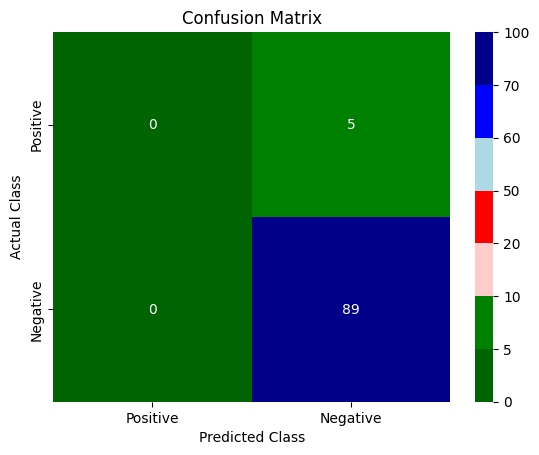

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define your color boundaries and corresponding colors
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

__________________

## Eliminating  features

In [24]:
best_estimator = best_model.best_estimator_

In [38]:
search_RFE = RFECV(best_estimator.named_steps[nsteps], cv=10, scoring="accuracy", n_jobs = multiprocessing.cpu_count() - 1, verbose=3)

In [39]:
%%time
search_RFE.fit(X_train, y_train)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
CPU times: user 59.4 s, sys: 0 ns, total: 59.4 s
Wall time: 3min

RFECV(cv=10,
      estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                   n_estimators=300),
      n_jobs=11, scoring='accuracy', verbose=3)

In [40]:
prediction = search_RFE.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FN,5,5
not true,89,89


# Confusion Matrix after eliminating features

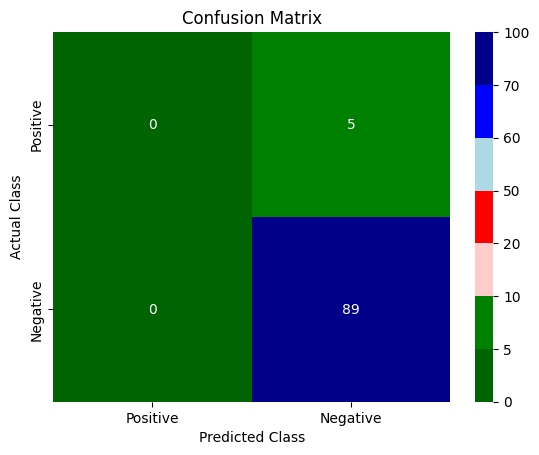

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

In [41]:
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

## Saving the model

In [ ]:
#model_path = f"./models/{label}_{classifier_name}.model"
#joblib.dump(best_model, model_path)

#print(f"Model saved successfully at {model_path}")